# Initial prediction using fine-tuned RNN-LSTM network.
####steps in training and fine-tuning
* clean the dataset using "cleanup_smiles.py"
* Train it using RNN-LSTM network and save the results as gen_0.smi and the keras model
* add already promising SMILES such as HIV & Remdeasivir in to these file
* Fine tune it to get gen_1.smi and gen1 keras weight file and so on.
* Fine tune uses Transfer learning which is clear and genetic algorithm

###The prediction is done on the cleaned dataset and the result is saved as .smi file
### Then we put additional Remdesivir and HIV inhibitors SMILES in to the saved file

In [0]:
!conda install -c rdkit rdkit

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.4
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs: 
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libxcb-1.13                |       h1bed415_1         502 KB
    mkl-2020.0                 |              166       202.1 MB
    libuuid-1.0.3              |       h1bed415_2 

In [0]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [0]:
!pip install bunch

In [0]:
import numpy as np
from copy import copy

import keras

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.generator import LSTMChemGenerator
from lstm_chem.trainer import LSTMChemTrainer
from lstm_chem.data_loader import DataLoader

In [0]:
CONFIG_FILE = 'experiments/2020-05-07/LSTM_Chem/config.json'
config = process_config(CONFIG_FILE)

In [0]:
modeler = LSTMChem(config, session='train')

In [0]:
train_dl = DataLoader(config, data_type='train')

In [0]:
valid_dl = copy(train_dl)
valid_dl.data_type = 'valid'

In [0]:
trainer = LSTMChemTrainer(modeler, train_dl, valid_dl)

In [0]:
%reload_ext tensorboard
%tensorboard --logdir experiments/2020-05-07/LSTM_Chem/logs

#Training

In [0]:
trainer.train()

In [0]:
# Save weights of the trained model
trainer.model.save_weights('experiments/2020-05-07/LSTM_Chem/checkpoints/LSTM_Chem-baseline-model-full.hdf5')

# Load the model and GENERATE new molecules

In [0]:
config['model_weight_filename'] = 'experiments/2020-05-07/LSTM_Chem/checkpoints/LSTM_Chem-baseline-model-full.hdf5'
print(config)

In [0]:
modeler = LSTMChem(config, session='generate')
generator = LSTMChemGenerator(modeler)
print(config)

In [0]:
sample_number = 10000
sampled_smiles = generator.sample(num=sample_number)

In [0]:
from rdkit import RDLogger, Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
RDLogger.DisableLog('rdApp.*')

In [0]:
valid_mols = []
for smi in sampled_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols.append(mol)
# low validity
print('Validity: ', f'{len(valid_mols) / sample_number:.2%}')

valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]
# high uniqueness
print('Uniqueness: ', f'{len(set(valid_smiles)) / len(valid_smiles):.2%}')

# Of valid smiles generated, how many are truly original vs ocurring in the training data
import pandas as pd
training_data = pd.read_csv('chembl_22_clean_1576904_sorted_std_final_cleaned.smi', header=None)
training_set = set(list(training_data[0]))
original = []
for smile in valid_smiles:
    if not smile in training_set:
        original.append(smile)
print('Originality: ', f'{len(set(original)) / len(set(valid_smiles)):.2%}')

In [0]:
with open('generation_0.smi.smi', 'w') as f:
    for item in valid_smiles:
        f.write("%s\n" % item)

# LogP optimization

In [0]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [0]:
use_cuda = torch.cuda.is_available()

In [0]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Setting up the generator

### Loading data for the generator

In [0]:
gen_data_path = 'generation_0.smi'

In [0]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [0]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [0]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.0) & 
                                     (prediction <= 5.0))/len(prediction)
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.0)
    plt.axvline(x=5.0)
    ax.set(xlabel='Predicted LogP', 
           title='Distribution of predicted LogP for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts logP for valid SMILES

4) plots histogram of predicted logP

5) Returns valid SMILES and their predicted logPs

In [0]:
def estimate_and_update(generator, predictor, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, use_tqdm=True)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

<img src="./figures/generator.png">

Initialize stack-augmented generative RNN:

In [0]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

If you want train the model from scratch, uncomment the lines below:

In [0]:
model_path = './checkpoints/generator/checkpoint_biggest_rnn'

In [0]:
#losses = my_generator.fit(gen_data, 1500000)

In [0]:
#plt.plot(losses)

In [0]:
#my_generator.evaluate(gen_data)

In [0]:
#my_generator.save_model(model_path)

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [0]:
my_generator.load_model(model_path)

## Setting up the predictor

For this demo we will use Recurrent Neural Network, i.e. unidirectional LSTM with 2 layers. The network is trained in 5-fold cross validation manner using the OpenChem toolkit (https://github.com/Mariewelt/OpenChem). In this demo we only upload the pretrained model. The training demo is in *RecurrentQSAR-example-logp.ipynb* file in the same directory. 

In [0]:
! git clone --single-branch --branch develop https://github.com/Mariewelt/OpenChem.git

Cloning into 'OpenChem'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 1551 (delta 19), reused 31 (delta 6), pack-reused 1492
Receiving objects: 100% (1551/1551), 108.61 MiB | 63.90 MiB/s, done.
Resolving deltas: 100% (776/776), done.
Checking connectivity... done.


In [0]:
sys.path.append('./OpenChem/')

In [0]:
from rnn_predictor import RNNPredictor

In [0]:
predictor_tokens = tokens + [' ']

In [0]:
path_to_params = './checkpoints/logP/model_parameters.pkl'
path_to_checkpoint = './checkpoints/logP/fold_'

In [0]:
my_predictor = RNNPredictor(path_to_params, path_to_checkpoint, predictor_tokens)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Here we produce the unbiased distribution of the property:

Generating molecules...:   0%|          | 0/10000 [00:00<?, ?it/s]/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Calculating predictions...: 100%|██████████| 82/82 [00:00<00:00, 714.37it/s]
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()


Percentage of predictions within drug-like region: 0.43902439024390244
Proportion of valid SMILES: 0.0082


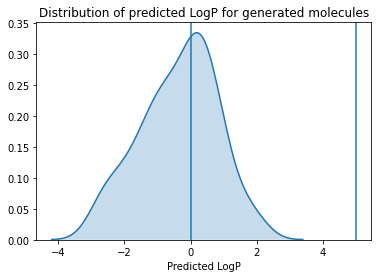

In [0]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=10000)

## Biasing the distribution of the generator with reinforcement learning (policy gradient)

We combine the generator and the predictor into a single pipeline. The generator produces new SMILES string, which is then evaluated by the predictor. Based on the obtain prediction and our goal, we assign a numerical reward value and update the parameters of the generator using policy gradient algorithm.

<img src="./figures/rl_pipeline.png">

Policy gradient loss is defined as:
$$
L(S|\theta) = -\dfrac{1}{n}\sum_{i=1}^{|S|} \sum_{j=1}^{length(s_i)} R_i\cdot \gamma^i \cdot \log p(s_i|s_0 \dots s_{i-1}\theta),
$$

where $R_i$ is the reward obtained at time step $i$ $\gamma$ is the discount factor and $p(s_i|s_0 \dots s_{i-1}, \theta)$ is the probability of the next character given the prefix, which we obtain from the generator. 

In our case the reward is the same for every time step and is equal to the reward for the whole molecule. Discount factor $\gamma$ is a number close to $1.0$ (it could be $1.0$).

### Optimizing logP to be in drug like region

In [0]:
from reinforcement import Reinforcement

Making a copy of the generator that will be optimized

In [0]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [0]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 100

In [0]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

The reward function we will use here is the following:

$$
R =  \begin{cases} 11.0, & \mbox{if } 1.0 < \log P < 4.0 \\ 1.0, & \mbox{otherwise}  \end{cases}
$$

In [0]:
def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    mol, prop, nan_smiles = predictor.predict([smiles])
    if len(nan_smiles) == 1:
        return invalid_reward
    if (prop[0] >= 1.0) and (prop[0] <= 4.0):
        return 11.0
    else:
        return 1.0

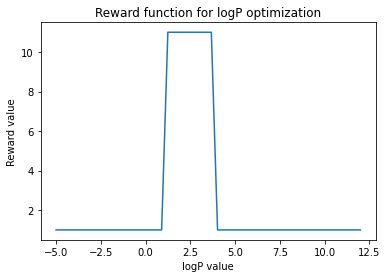

In [0]:
x = np.linspace(-5, 12)
reward = lambda x: 11.0 if ((x > 1.0) and (x < 4.0)) else 1.0
plt.plot(x, [reward(i) for i in x])
plt.xlabel('logP value')
plt.ylabel('Reward value')
plt.title('Reward function for logP optimization')
plt.show()

In [0]:
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

In [0]:
rewards = []
rl_losses = []

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [10:32<00:00, 42.20s/it]


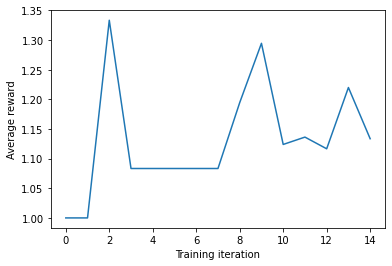

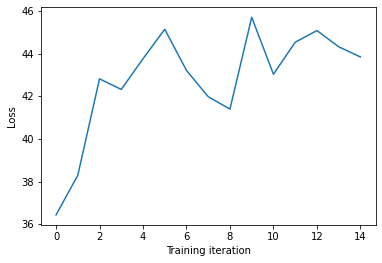

Calculating predictions...: 100%|██████████| 4/4 [00:00<00:00, 400.70it/s]


Percentage of predictions within drug-like region: 0.5
Proportion of valid SMILES: 0.02


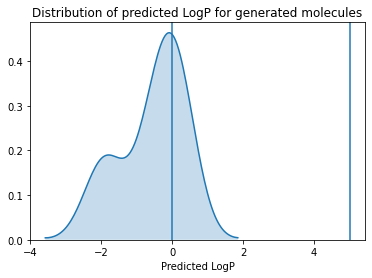

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
No
P 
S 
c 


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [08:57<00:00, 35.86s/it]


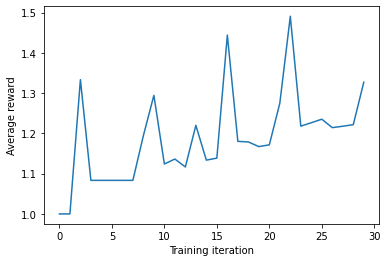

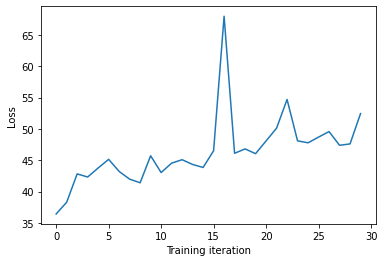

Calculating predictions...: 100%|██████████| 2/2 [00:00<00:00, 199.33it/s]


Percentage of predictions within drug-like region: 0.5
Proportion of valid SMILES: 0.01


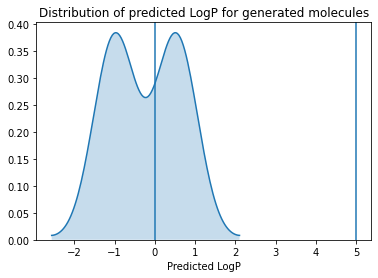

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
BP
p 


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [09:10<00:00, 36.71s/it]


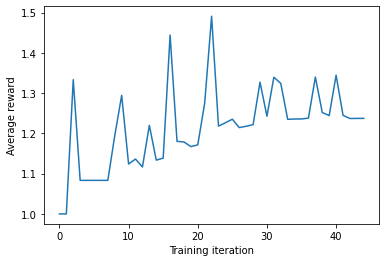

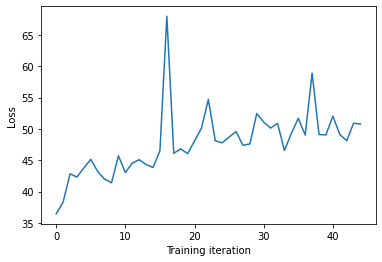

Calculating predictions...: 100%|██████████| 5/5 [00:00<00:00, 464.49it/s]


Percentage of predictions within drug-like region: 0.4
Proportion of valid SMILES: 0.025


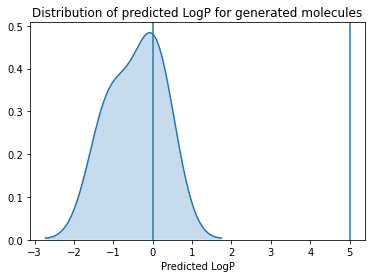

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
F 
c 
o 
oI
s 


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [07:03<00:00, 28.24s/it]


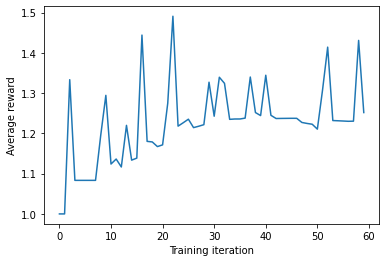

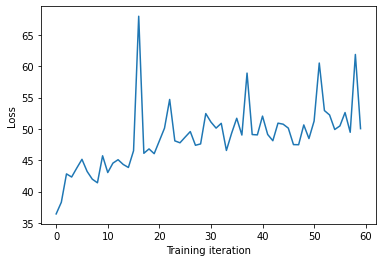

Calculating predictions...: 100%|██████████| 8/8 [00:00<00:00, 666.57it/s]


Percentage of predictions within drug-like region: 0.5
Proportion of valid SMILES: 0.04


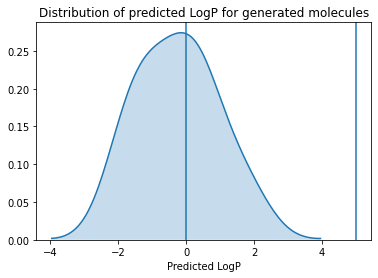

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
B   
CsCp
O   
OF  
OS  


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [06:46<00:00, 27.09s/it]


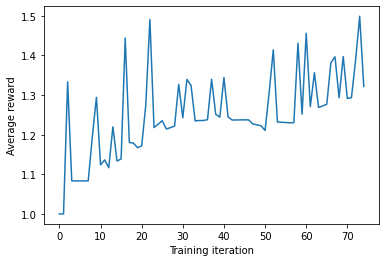

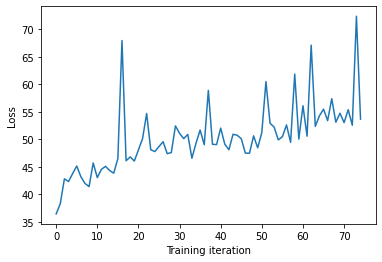

Calculating predictions...: 100%|██████████| 6/6 [00:00<00:00, 551.00it/s]


Percentage of predictions within drug-like region: 0.6666666666666666
Proportion of valid SMILES: 0.03


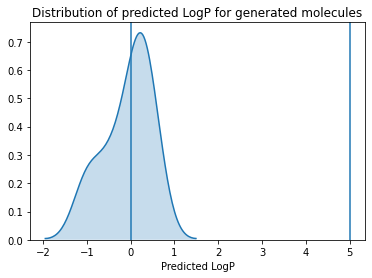

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
B  
BP 
c  
cSO
p  


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [07:32<00:00, 30.20s/it]


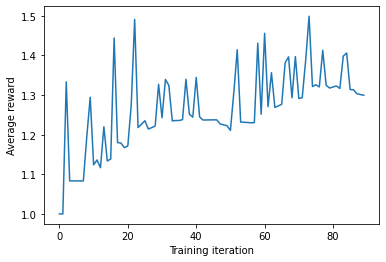

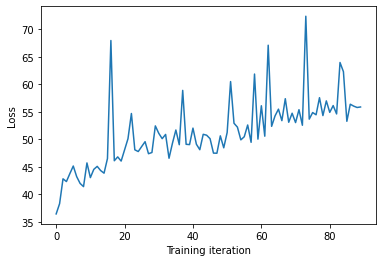

Calculating predictions...: 100%|██████████| 1/1 [00:00<00:00, 638.01it/s]
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.005


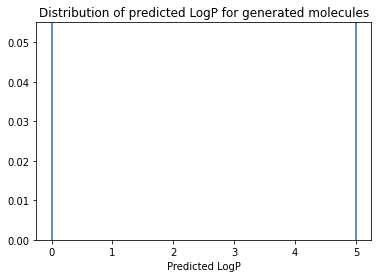

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
N
F
F


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [07:36<00:00, 30.40s/it]


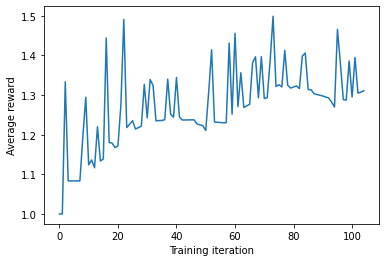

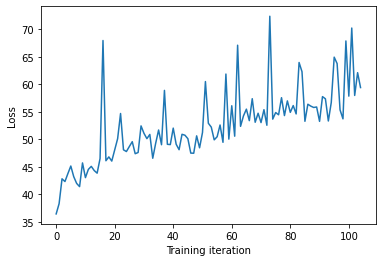

Calculating predictions...: 100%|██████████| 4/4 [00:00<00:00, 374.45it/s]


Percentage of predictions within drug-like region: 0.75
Proportion of valid SMILES: 0.02


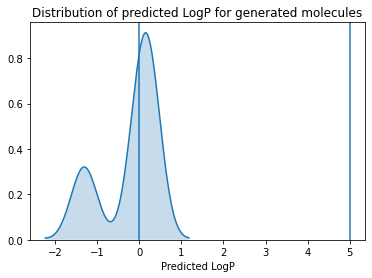

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
NF
S 
c 
s 


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [06:31<00:00, 26.13s/it]


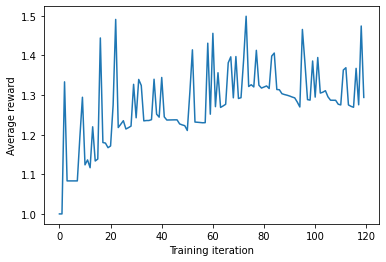

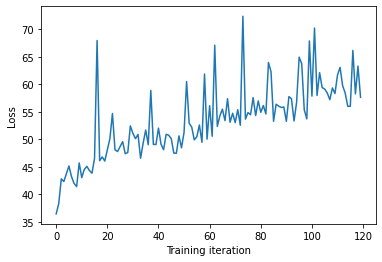

Calculating predictions...: 100%|██████████| 6/6 [00:00<00:00, 443.93it/s]


Percentage of predictions within drug-like region: 0.3333333333333333
Proportion of valid SMILES: 0.03


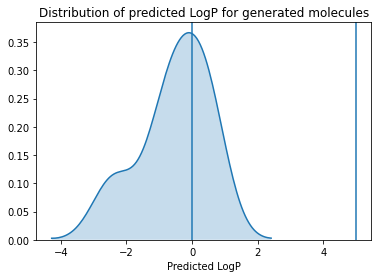

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
CP 
F  
I  
P  
POP


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [06:04<00:00, 24.29s/it]


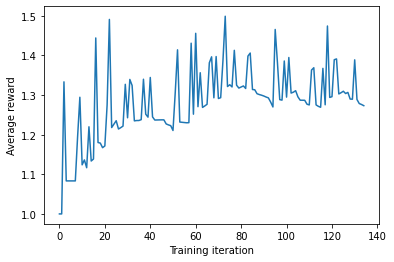

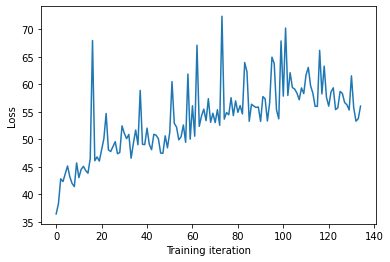

Calculating predictions...: 100%|██████████| 4/4 [00:00<00:00, 326.75it/s]


Percentage of predictions within drug-like region: 0.75
Proportion of valid SMILES: 0.02


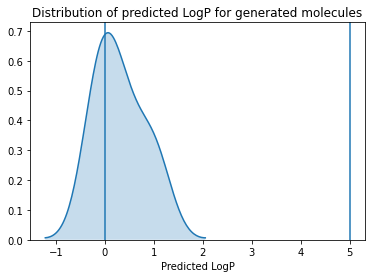

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
F  
F=I
I  
c  


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [05:09<00:00, 20.63s/it]


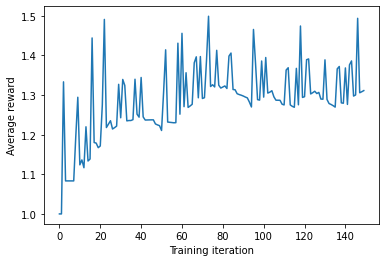

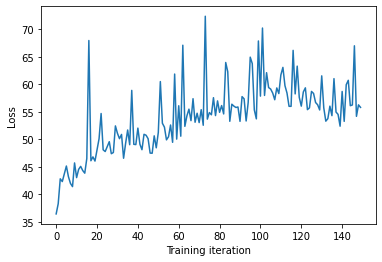

Calculating predictions...: 100%|██████████| 4/4 [00:00<00:00, 348.48it/s]


Percentage of predictions within drug-like region: 0.5
Proportion of valid SMILES: 0.02


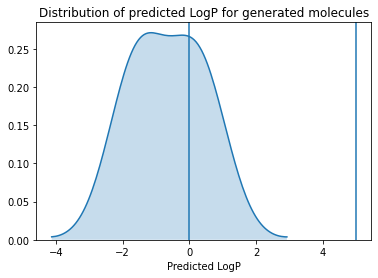

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
FP
I 
O 
n 


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [05:36<00:00, 22.42s/it]


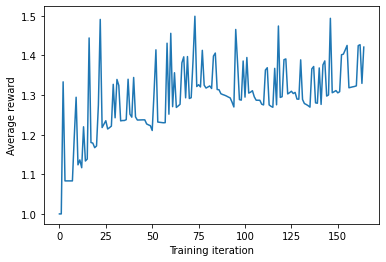

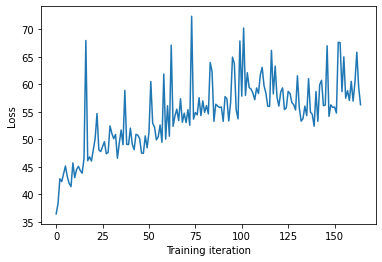

Calculating predictions...: 100%|██████████| 7/7 [00:00<00:00, 518.90it/s]


Percentage of predictions within drug-like region: 0.42857142857142855
Proportion of valid SMILES: 0.035


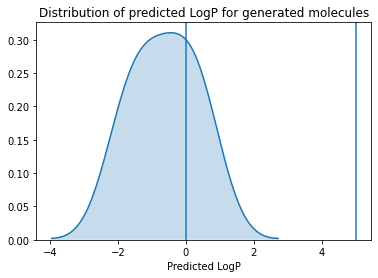

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
CO  
Cs  
N   
S   
c   


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [04:25<00:00, 17.68s/it]


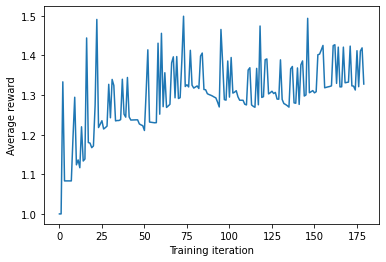

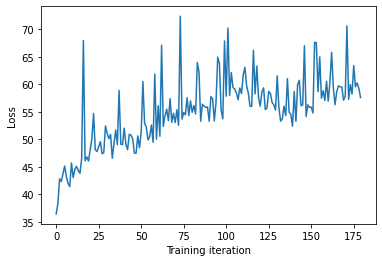

Calculating predictions...: 100%|██████████| 9/9 [00:00<00:00, 505.88it/s]


Percentage of predictions within drug-like region: 0.4444444444444444
Proportion of valid SMILES: 0.045


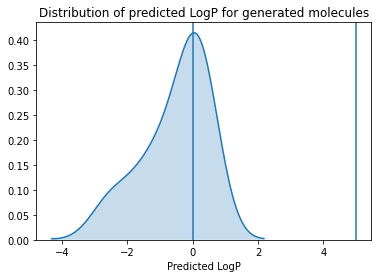

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
Fp 
I  
O  
P  
S  


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [04:25<00:00, 17.70s/it]


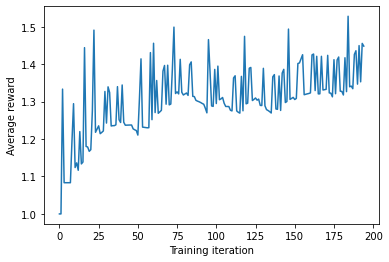

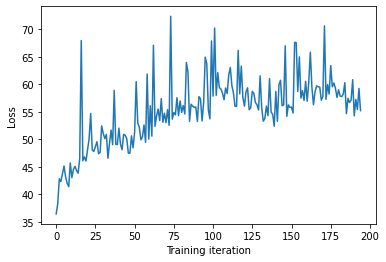

Calculating predictions...: 100%|██████████| 4/4 [00:00<00:00, 362.23it/s]


Percentage of predictions within drug-like region: 0.5
Proportion of valid SMILES: 0.02


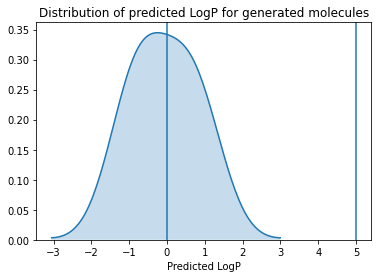

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
BI
C 
P 
p 


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [04:28<00:00, 17.89s/it]


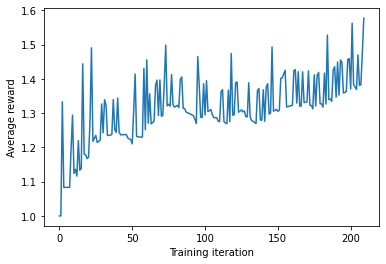

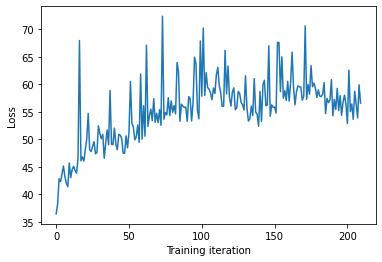

Calculating predictions...: 100%|██████████| 9/9 [00:00<00:00, 525.84it/s]


Percentage of predictions within drug-like region: 0.3333333333333333
Proportion of valid SMILES: 0.045


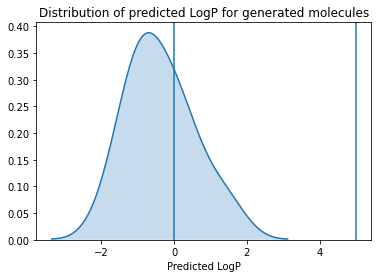

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
B.Ps
CPnP
F   
I   
N   


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [03:36<00:00, 14.41s/it]


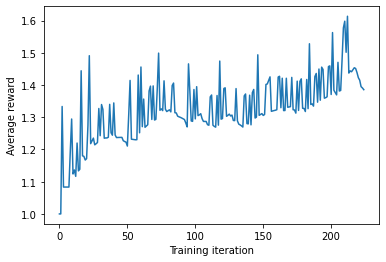

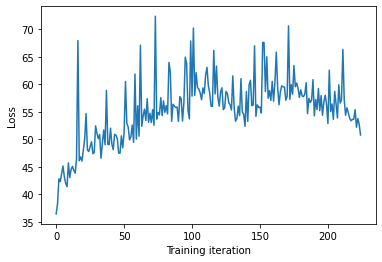

Calculating predictions...: 100%|██████████| 6/6 [00:00<00:00, 536.91it/s]


Percentage of predictions within drug-like region: 0.3333333333333333
Proportion of valid SMILES: 0.03


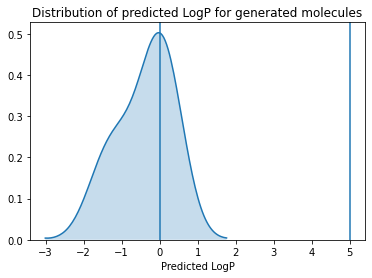

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
B  
BCO
F  
n  
o  


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [03:57<00:00, 15.84s/it]


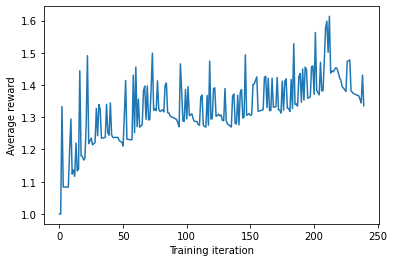

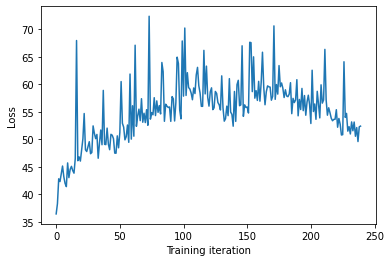

Calculating predictions...: 100%|██████████| 12/12 [00:00<00:00, 682.22it/s]


Percentage of predictions within drug-like region: 0.5833333333333334
Proportion of valid SMILES: 0.06


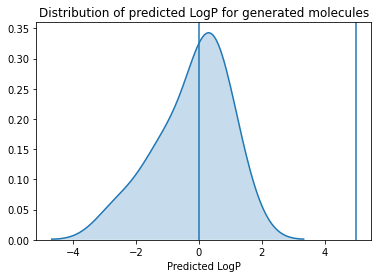

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
B   
BI  
CI  
I   
N   


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [03:28<00:00, 13.88s/it]


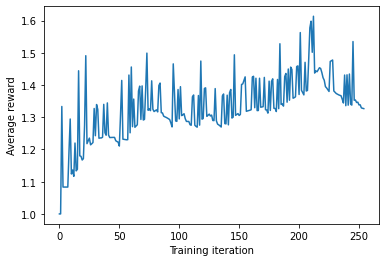

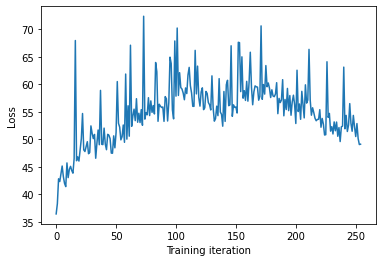

Calculating predictions...: 100%|██████████| 9/9 [00:00<00:00, 442.24it/s]


Percentage of predictions within drug-like region: 0.3333333333333333
Proportion of valid SMILES: 0.045


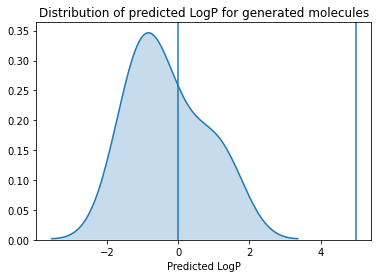

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=n
CI 
II 
P  
PS 


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [03:55<00:00, 15.68s/it]


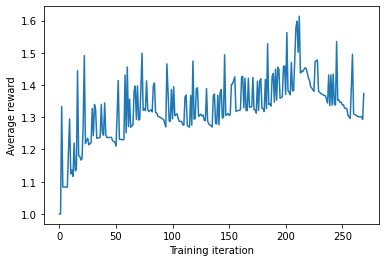

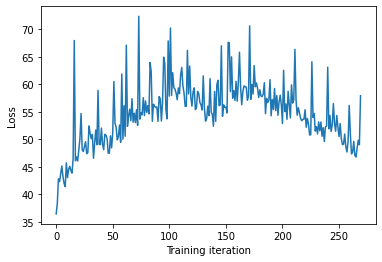

Calculating predictions...: 100%|██████████| 6/6 [00:00<00:00, 364.91it/s]


Percentage of predictions within drug-like region: 0.6666666666666666
Proportion of valid SMILES: 0.03


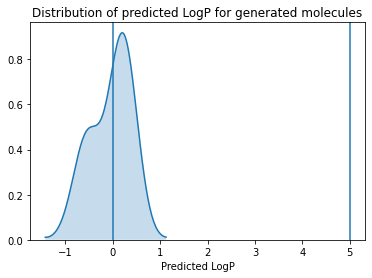

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
B  
BN 
BOI
P  
S  


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [03:37<00:00, 14.51s/it]


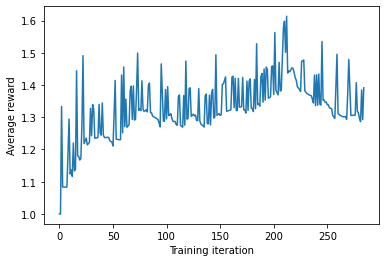

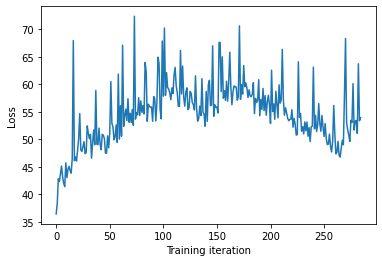

Calculating predictions...: 100%|██████████| 11/11 [00:00<00:00, 734.32it/s]


Percentage of predictions within drug-like region: 0.5454545454545454
Proportion of valid SMILES: 0.055


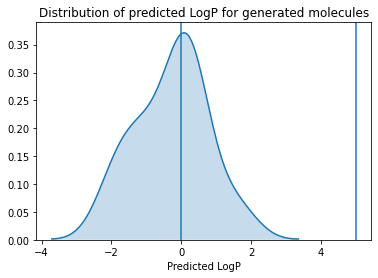

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
B  
F  
I  
No 
Ns 


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [02:46<00:00, 11.10s/it]


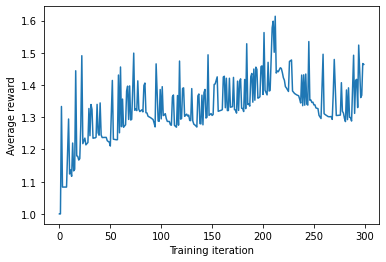

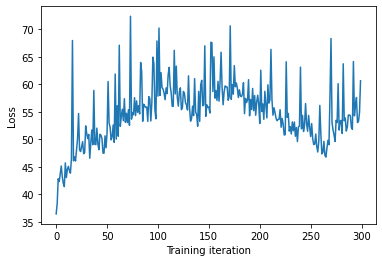

Calculating predictions...: 100%|██████████| 10/10 [00:00<00:00, 537.11it/s]


Percentage of predictions within drug-like region: 0.4
Proportion of valid SMILES: 0.05


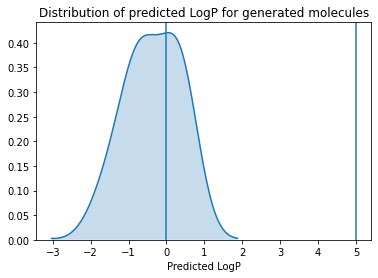

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
Bo    
C     
CN    
Co    
I     


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [03:19<00:00, 13.29s/it]


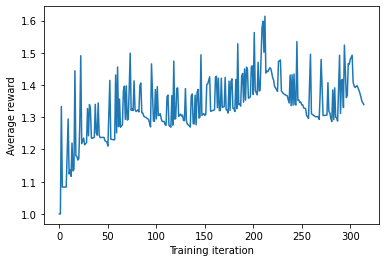

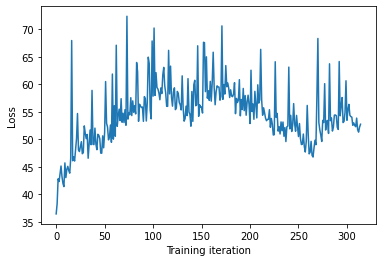

Calculating predictions...: 100%|██████████| 13/13 [00:00<00:00, 541.22it/s]


Percentage of predictions within drug-like region: 0.6153846153846154
Proportion of valid SMILES: 0.065


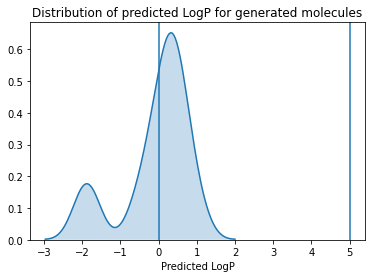

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
B  
BoI
C  
CP 
F  


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...: 100%|██████████| 15/15 [02:48<00:00, 11.20s/it]


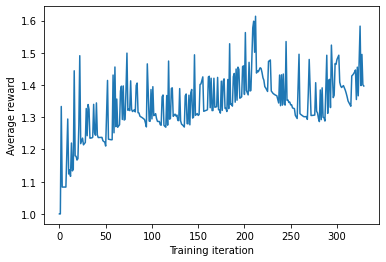

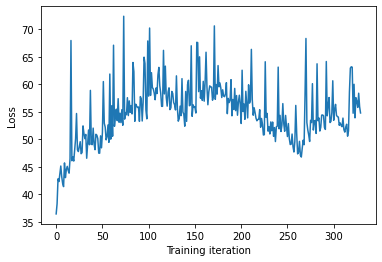

Calculating predictions...: 100%|██████████| 8/8 [00:00<00:00, 389.95it/s]


Percentage of predictions within drug-like region: 0.625
Proportion of valid SMILES: 0.04


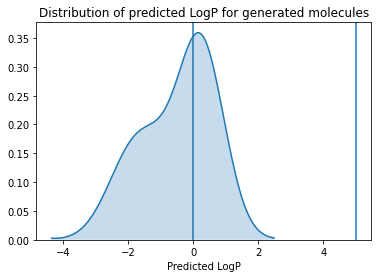

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
B   
BpO 
C   
NsIn
O   


/content/drive/My Drive/samhar/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...:  87%|████████▋ | 13/15 [02:32<00:25, 12.61s/it]

In [0]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

Calculating predictions...: 100%|██████████| 6894/6894 [00:04<00:00, 1492.81it/s]


Percentage of predictions within drug-like region: 0.979982593559617
Proportion of valid SMILES: 0.6894


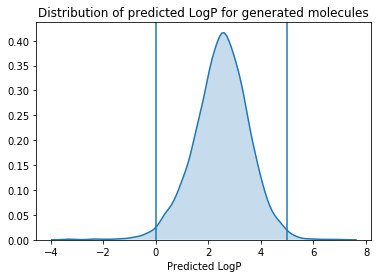

In [0]:
smiles_biased, prediction_biased = estimate_and_update(RL_logp.generator, 
                                                       my_predictor,
                                                       n_to_generate=10000)

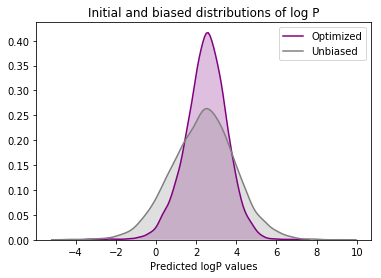

In [0]:
sns.kdeplot(prediction_biased, label='Optimized', shade=True, color='purple')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('Predicted logP values')
plt.title('Initial and biased distributions of log P')
plt.legend()
plt.show()

### Drawing random molecules

Now we will draw some random compounds from the biased library:

In [0]:
from rdkit.Chem import Draw

In [0]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [0]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased]

In [0]:
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]

In [0]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['log P = ' + str(prediction_biased[i]) for i in ind]

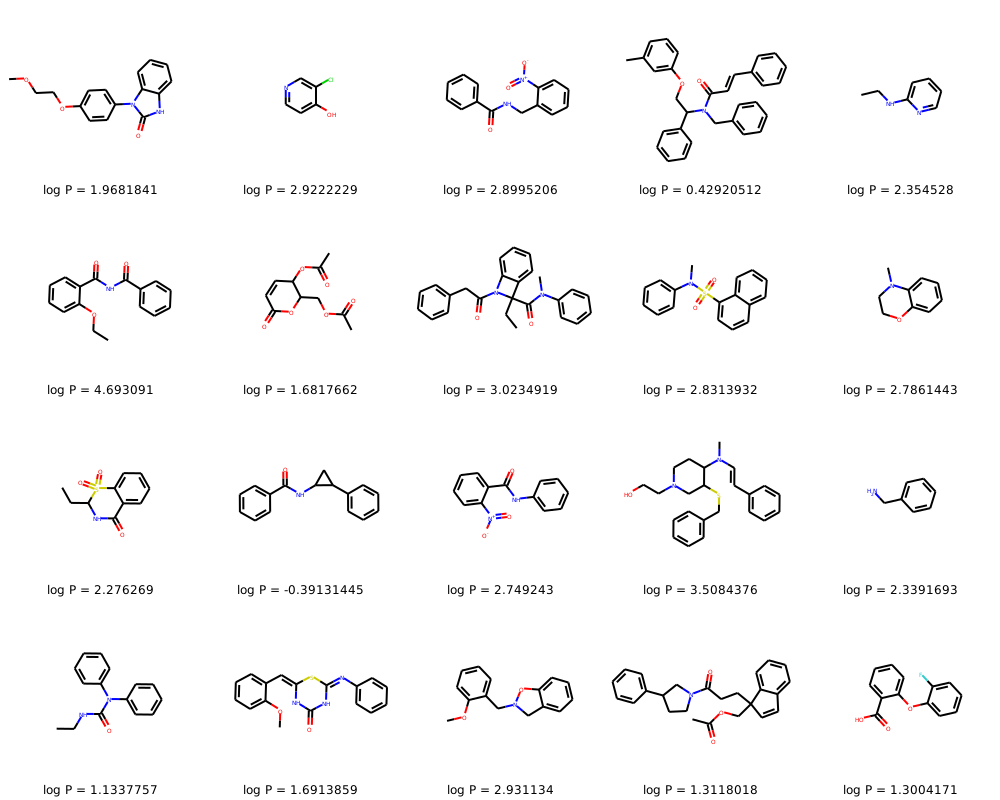

In [0]:
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, 
                     subImgSize=(200,200), legends=legends)

##Save the molecules as SMILES

In [0]:
sampled_smiles = sanitized_gen_mols
valid_mols = []
for smi in sampled_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols.append(mol)


valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]

In [0]:
with open('final_data.smi', 'w') as f:
    for item in valid_smiles:
        f.write("%s\n" % item)

#process generated smiles for PyRx analysis

In [0]:

import pandas as pd
from rdkit import Chem, DataStructs
import random
import numpy as np
import rdkit.Chem.PropertyMol

In [0]:

gen0_table = pd.read_csv('final_data.smi',sep=',', header=None)
gen0 = list(gen0_table[0])[0:10000]
len(gen0)

In [0]:

def validate_mols(list_of_smiles):
    valid_mols = []
    for smi in list_of_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_mols.append(mol)
    return valid_mols

def convert_mols_to_smiles(list_of_mols):
    valid_smiles = [Chem.MolToSmiles(mol) for mol in list_of_mols]
    return valid_smiles

In [0]:

gen0_mols = validate_mols(gen0)
len(gen0_mols)

In [0]:

'''Intakes a list of smiles, randomly shuffles them, then adds first thirty,
then sets a max-similarity threshold between any new molecule and existing list
and iteratively increases the treshold until X components are picked to ensure diveristy'''

def initialize_generation_from_mols(list_of_mols,desired_length):  
    assert desired_length >30
    random.shuffle(list_of_mols)
    random.shuffle(list_of_mols)
    
    #Prepare fingerprints for similarity calcs
    mol_fingerprints = []
    for mol in list_of_mols:
        mol_fingerprints.append(Chem.RDKFingerprint(mol))
    
    selected_mols = list_of_mols[0:30]
    selected_fingerprints = mol_fingerprints[0:30]
    remaining_mols = list_of_mols[30:]
    remaining_fingerprints = mol_fingerprints[30:]
    
    similarity_threshold = .05   
    while len(selected_mols) < desired_length:
        for fingerprint, mol in zip(remaining_fingerprints, remaining_mols):
            max_similarity = np.max(DataStructs.BulkTanimotoSimilarity(fingerprint,selected_fingerprints))
            if (max_similarity <= similarity_threshold) and (max_similarity < 1):
                selected_fingerprints.append(fingerprint)
                selected_mols.append(mol)
        print("Completed loop with threshold at: ", similarity_threshold, ". Length is currently: ", len(selected_mols))
        similarity_threshold += .05
    return selected_mols

In [0]:
gen0_mols = initialize_generation_from_mols(gen0_mols,1000)
print(len(gen0_mols))

In [0]:
master_table = pd.read_csv('./generations/master_results_table.csv',sep=',')
master_table.shape[0]

In [0]:
'''Certainly not opimized and not strictly necessary, but in the PyRx GUI
molecule names would sort oddly when in any numeric order, so ordering
molcules by a four letter code. This function iterates the four letter code.'''
def iterate_alpha(alpha_code):
    numbers = []
    for letter in alpha_code:
        number = ord(letter)
        numbers.append(number)
    
    if numbers[3]+1 > 90:
        if numbers[2]+1 > 90:
            if numbers[1]+1 > 90:
                if numbers[0]+1 > 90:
                    raise ValueError('Too long for alpha code')
                else:
                    numbers[3] = 65
                    numbers[2] = 65
                    numbers[1] = 65
                    numbers[0] = numbers[0] + 1
            else:
                numbers[3] = 65
                numbers[2] = 65
                numbers[1] = numbers[1] + 1
        else:
            numbers[3] = 65
            numbers[2] = numbers[2] + 1
    else:
        numbers[3] = numbers[3] + 1
    

    new_code = ""
    for number in numbers:
        new_code += chr(number)
    return new_code
iterate_alpha('AAAA')

In [0]:
def append_to_tracking_table(master_table,mols_to_append, source, generation):
    # Assign IDs for tracking to each mol, and assign a pandas table entry for each
    mols_to_export = []
    rows_list = []
    
    master_table_gen = master_table[master_table['gen'] == generation]
    if master_table_gen.shape[0] == 0:
        id_code = 'AAAA'
    else:
        master_table_gen_ids = master_table_gen.sort_values('id', ascending=True)
        master_table_gen_max_id = master_table_gen_ids.tail(1)
        key = master_table_gen_max_id['id'].keys()[0]
        id_code = iterate_alpha(str(master_table_gen_max_id['id'][key]))
        
    training_data = pd.read_csv('./datasets/all_smiles_clean.smi', header=None)
    training_set = set(list(training_data[0]))
    
    for mol in mols_to_append:
        pm = Chem.PropertyMol.PropertyMol(mol)
        title = 'id' + str(id_code) + 'gen'+ str(generation)
        print(title)
        # Enables for tracking which molecule is which in PyRx GUI and PyRx results export
        pm.SetProp('Title', title)
        mols_to_export.append(pm)

        #And track in pandas
        mol_dict = {}
        mol_dict['id'] = id_code
        mol_dict['gen'] = generation
        smile = Chem.MolToSmiles(mol)
        assert type(smile) == type('string')
        mol_dict['smile'] = smile

        if (source!= 'hiv' and source != 'manual' and source != 'baseline') and (smile in training_set):
            mol_dict['source'] = 'training'
        else:
            mol_dict['source'] = source
        mol_dict['score'] = 99.9

        rows_list.append(mol_dict)
        id_code = iterate_alpha(id_code)
        
    df = pd.DataFrame(rows_list)
    return df, mols_to_export

In [0]:
new_mols_to_test = append_to_tracking_table(master_table,gen0_mols, 'generated', 0)
mols_for_pd = new_mols_to_test[0]
mols_for_export = new_mols_to_test[1]
master_table = master_table.append(mols_for_pd)
len(mols_for_export)

In [0]:
master_table = master_table.reset_index(drop=True)
master_table.to_csv(r'./generations/master_results_table.csv', index=False)

In [0]:
# Add HIV inhibitors manually into the table
hiv_smiles = pd.read_csv('./datasets/hiv_inhibitors_cleaned.smi',sep=',', header=None)
hiv_smiles = list(hiv_smiles[0])
hiv_mols = validate_mols(hiv_smiles)

master_table = pd.read_csv('./generations/master_results_table.csv',sep=',')
new_mols_to_test = append_to_tracking_table(master_table,hiv_mols, 'hiv', 0)
mols_for_pd = new_mols_to_test[0]
mols_for_export = mols_for_export + new_mols_to_test[1]

master_table = master_table.append(mols_for_pd)
master_table = master_table.reset_index(drop=True)
master_table.to_csv(r'./generations/master_results_table.csv', index=False)

In [0]:
# Add a few other smiles manually into the table ("control group" of training smiles)
manual_smiles = pd.read_csv('./datasets/manual_testing_cleaned.smi',sep=',', header=None)
manual_smiles = list(manual_smiles[0])
manual_mols = validate_mols(hiv_smiles)

master_table = pd.read_csv('./generations/master_results_table.csv',sep=',')
new_mols_to_test = append_to_tracking_table(master_table,manual_mols, 'manual', 0)
mols_for_pd = new_mols_to_test[0]
mols_for_export = mols_for_export + new_mols_to_test[1]

master_table = master_table.append(mols_for_pd)
master_table = master_table.reset_index(drop=True)
master_table.to_csv(r'./generations/master_results_table.csv', index=False)

In [0]:
def write_gen_to_sdf(mols_for_export, generation, batch_size):
    if len(mols_for_export) > batch_size:
        batches = (len(mols_for_export) // 1000)+1
        for i in range(0,batches):
            batch_to_export = mols_for_export[i*batch_size:(i+1)*batch_size]
            w = Chem.SDWriter('./generations/gen_new.sdf')
            for m in batch_to_export: w.write(m)
    else:
        w = Chem.SDWriter('./generations/gen_new_final.sdf')
        for m in mols_for_export:
            w.write(m)
    
    # Noticed an issue where the very last line item of an sdf write is not written correctly until another arbitary write is made
    w = Chem.SDWriter('./generations/junk/test.sdf')
    w.write(m)
    
    return mols_for_export

In [0]:
write_gen_to_sdf(mols_for_export, 0, 2000)
print('ok')

##NOW GO TO PyRx: Analyze the SDF file and compare it with Remdesivir